# Analysis of building permits, assessed housing values, and zoning changes

### Primary Questions
- How have available units for affordable housing and workforce housing changed over time (since 2010)?
    - Affordability based on 68,000 Median Household Income
    - Affordable housing defined as no more than 30% of household income for families at 60% of the MHI or less

- How do demolitions and rebuilds affect the availability of affordable housing?

- How have zoning changes affected the availability of affordable housing?

- What does the shortage of affordable housing look like now? What do we expect it to look like in 2025?




In [66]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as BS
import numpy as np
import re
import requests
import folium
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import seaborn as sns

%matplotlib inline
# Increasing default figure size of the notebook
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 18

In [2]:
# Read in data from txt files
value_df2009 = pd.read_csv('Data/2009_single family_final_with_sqft.txt')
value_df2013 = pd.read_csv('Data/2013_single family_final_with_sqft.txt')
value_df2017 = pd.read_csv('Data/2017_single family_final_with_sqft.txt')
value_df2009.columns = ['apn', 'dist_code', 'council_dist', 'address', 'city', 'zip', '2009_land', '2009_impr', 
                        '2009_appr', '2009_assd', 'sq_ft']
value_df2013.columns = ['apn', 'dist_code', 'council_dist', 'address', 'city', 'zip', '2013_land', '2013_impr', 
                        '2013_appr', '2013_assd', 'sq_ft']
value_df2017.columns = ['apn', 'dist_code', 'council_dist', 'address', 'city', 'zip', '2017_land', '2017_impr', 
                        '2017_appr', '2017_assd', 'sq_ft']

In [3]:
build_permits = pd.read_csv('Data/Building_Permits_Issued.csv', low_memory=False)


In [4]:
value_df2009.head(5)

,apn,dist_code,council_dist,address,city,zip,2009_land,2009_impr,2009_appr,2009_assd,sq_ft
0,00200000300,RT,10,1012 OLD BUCK HILL RD,GOODLETTSVILLE,37072,49800.0,65700.0,115500.0,28875.0,1920.0
1,00200000700,RT,10,1109 HIGHLAND AVE,GOODLETTSVILLE,37072,44100.0,88700.0,132800.0,33200.0,1464.0
2,00200001001002,GSD,10,0 SPRINGFIELD HWY,GOODLETTSVILLE,37072,15000.0,137900.0,152900.0,38225.0,3539.0
3,00200001400001,RT,10,133 B EAST END RD,GOODLETTSVILLE,37072,41100.0,27000.0,68100.0,17025.0,736.0
4,00200001600001,RT,10,141 B EAST END RD,GOODLETTSVILLE,37072,25100.0,60900.0,86000.0,21500.0,1301.0


In [5]:
value_df2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197114 entries, 0 to 197113
Data columns (total 11 columns):
apn             197114 non-null object
dist_code       197114 non-null object
council_dist    197114 non-null int64
address         197114 non-null object
city            197114 non-null object
zip             197114 non-null int64
2017_land       197114 non-null int64
2017_impr       197114 non-null int64
2017_appr       197114 non-null int64
2017_assd       197114 non-null int64
sq_ft           197114 non-null float64
dtypes: float64(1), int64(6), object(4)
memory usage: 16.5+ MB


In [6]:
build_permits.head(10)

,Permit #,Permit Type Description,Permit Subtype Description,Parcel,Date Entered,Date Issued,Const. Cost,Address,City,State,Zip,Subdivision/Lot,Contact,Permit Type,Permit Subtype,IVR Trk#,Purpose,Council Dist,Census Tract,Mapped Location
0,2018002927,Building Residential - New,Single Family Residence,081160R00100CO,01/18/2018,02/12/2018,206150.0,1017A MONROE ST,NASHVILLE,TN,37208,UNIT A 1017 MONROE,"TRISTAR CONSTRUCTION, INC",CARN,CAA01R301,3439281,to construct 1830SF single family residence wi...,19.0,37019400.0,"1017A MONROE ST\nNASHVILLE, TN 37208\n(36.1740..."
1,201617929,Building Use & Occupancy,"Tents, Stages",09215014800,04/19/2016,04/21/2016,2000.0,2300 WEST END AVE,NASHVILLE,TN,37203,N W CORNER WEST END AVE & 23RD AVE N,Music City Tents & Events Llc,CAUO,CAZ06A001,2116751,PERMIT TO ERECT 1:40X85 TENT. THIS TENT IS BEI...,21.0,37016500.0,"2300 WEST END AVE\nNASHVILLE, TN 37203\n(36.14..."
2,2016049270,Building Sign Permit,Sign - Ground / Wall Signs,11909014000,09/14/2016,09/14/2016,15000.0,2802 NOLENSVILLE PIKE,NASHVILLE,TN,37211,PT LOT 2 PATTERSON SUB,BOZMAN SIGN CO INC,CASN,CAZ02A001,3277064,to install replacement signage for existing fr...,16.0,37017300.0,"2802 NOLENSVILLE PIKE\nNASHVILLE, TN 37211\n(3..."
3,2016029907,Building Residential - Roofing / Siding,Duplex,075150A13900CO,06/20/2016,06/20/2016,17648.0,139 STONERS GLEN DR,HERMITAGE,TN,37076,UNIT 139 STONERS GLEN PHASE 1,"MR ROOF NASHVILLE, LLC",CARK,CAA02R302,3251947,Remove existing shingles and replace with new ...,12.0,37015623.0,"139 STONERS GLEN DR\nHERMITAGE, TN 37076\n(36...."
4,201533533,Building Residential - Tenant Finish Out,"Multifamily, Tri-Plex, Quad, Apartments",10404024100,08/07/2015,11/17/2015,542696.0,70 MUSIC SQ W,NASHVILLE,TN,37203,LOT 1 O.B. HAYES FIRST PLAN CONSOLIDATION OF L...,Construction Enterprises Inc,CART,CAA03R398,2061885,SEE MASTER PERMIT T2015-26520...T.....GRAND AV...,19.0,37016400.0,"70 MUSIC SQ W\nNASHVILLE, TN 37203\n(36.147074..."
5,201605753,Building Residential - Rehab,Single Family Residence,131060E32200CO,02/10/2016,02/10/2016,50000.0,322 BOXMERE PL,NASHVILLE,TN,37215,UNIT 322 BURTON HILLS VILLAGE OF BOXMERE-PHASE 1,Sharp & Robbins Construction Llc,CARR,CAA01R301,2100747,to conduct interior renovation to existing uni...,25.0,37017902.0,"322 BOXMERE PL\nNASHVILLE, TN 37215\n(36.09425..."
6,2017032777,Building Residential - New,Single Family Residence,072103B00300CO,05/17/2017,05/24/2017,226201.0,1037 FAIRWIN AVE,NASHVILLE,TN,37216,UNIT 3 2619 GALLATIN PIKE TOWNHOMES,PARAGON GROUP LLC,CARN,CAA01R301,3367050,to construct 2008Sf single family residence wi...,5.0,37011400.0,"1037 FAIRWIN AVE\nNASHVILLE, TN 37216\n(36.198..."
7,201546095,Building Residential - Rehab,Single Family Residence,12809002600,10/22/2015,10/22/2015,30000.0,305 HARPETH VALLEY RD,NASHVILLE,TN,37221,LOT 35 B. V. 1776 ESTATES,"Odyssey Construction, Llc",CARR,CAA01R301,2078541,to make general repairs to existing residence....,22.0,37018301.0,"305 HARPETH VALLEY RD\nNASHVILLE, TN 37221\n(3..."
8,201619676,Building Commercial - Roofing / Siding,"Manufacturing, Light Hazardous (H1-H5)",09314033300,04/28/2016,04/28/2016,66961.0,625 FOGG ST,NASHVILLE,TN,37203,LOTS 30 TH 34 EWING & WETMORE,Ragan Construction Co Inc (Formerly Southern R...,CACK,CAH06H000,2119017,to reroof existing cromatics building.,19.0,37019500.0,"625 FOGG ST\nNASHVILLE, TN 37203\n(36.150909, ..."
9,201550728,Building Commercial - Foundation,"Multifamily, Apt / Twnhome > 5 Unit Bldg",08305009600,11/18/2015,02/01/2016,219566.0,1035 W EASTLAND AVE,NASHVILLE,TN,37206,"LOT 4 EDGEFIELD HOSPITAL, INC. RESUB",Southland Constructors Inc.,CACF,CAA03R399,2084584,"per shell permit 201550039, to conduct foundat...",5.0,37011700.0,"1035 W EASTLAND AVE\nNASHVILLE, TN 37206\n(36...."


In [7]:
build_permits.columns = ['permit_num', 'permit_descr', 'permit_subtype_descr', 'parcel', 'date_entered', 
                         'date_issued', 'const_cost', 'address', 'city', 'state', 'zip', 'subdivision', 'contact',
                        'permit_type', 'permit_subtype', 'ivr_trk', 'purpose', 'council_dist', 'census_tract', 'mapped_loc']

In [8]:
build_permits.date_entered = pd.to_datetime(build_permits.date_entered)


In [9]:
build_permits.date_issued = pd.to_datetime(build_permits.date_issued)

In [10]:
build_permits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36221 entries, 0 to 36220
Data columns (total 20 columns):
permit_num              36221 non-null object
permit_descr            36221 non-null object
permit_subtype_descr    36221 non-null object
parcel                  36221 non-null object
date_entered            36221 non-null datetime64[ns]
date_issued             36221 non-null datetime64[ns]
const_cost              36085 non-null float64
address                 36221 non-null object
city                    36093 non-null object
state                   36096 non-null object
zip                     36221 non-null int64
subdivision             36220 non-null object
contact                 36221 non-null object
permit_type             36221 non-null object
permit_subtype          36221 non-null object
ivr_trk                 36221 non-null int64
purpose                 35922 non-null object
council_dist            36141 non-null float64
census_tract            36039 non-null float64


 # 2017 Data
- 30% group with annual income of 20,400
    - 6,120 in housing
        - 510 per month
<br><br>
- 60% group with annual income of 40,800
    - 12,240 in housing
        - 1,020 per month
<br><br>
- 80% group with 54,400 per year
    - 16,320 in housing
        - 1,360 per month
<br><br>
- 120% group making 81,600 per year
    - 24,480 in housing
        - 2,040 per month

# 2009 Data
- 30% group with annual income of 19,500
    - 5,850 in housing
        - 487.50 per month
<br><br>
- 60% group with annual income of 39,000
    - 11,700 in housing
        - 975 per month
<br><br>
- 80% group with 52,000 per year
    - 15,600 in housing
        - 1,300 per month
<br><br>
- 120% group making 78,000 per year
    - 23,400 in housing
        - 1,950 per month

# 2013 Data
- 30% group with annual income of 18,690
    - 5,607 in housing
        - 467.25 per month
<br><br>
- 60% group with annual income of 37,380
    - 11,214 in housing
        - 934.50 per month
<br><br>
- 80% group with 49,840 per year
    - 14,952 in housing
        - 1,246 per month
<br><br>
- 120% group making 74,760 per year
    - 22,428 in housing
        - 1,869 per month

## Assuming 5% down payment, 4% mortgage rate, and 30 year mortgage when calculating home price that someone can afford

<br>
Factoring in property tax into affordability. Property tax in Nashville is 3.155% of Assessed Value (which is 25% of appraised value) <br>
Property tax is effectively 0.78% of home value <br>
Annual home insurance of 900 per year also factored into payment
<br><br>
- 30% group
    - 85,000 home 
- 60% group
    - 185,000
- 80% group
    - 250,000
- 120% group
    - 375,000

2009 AMI: 65,000<br><br>
2013 AMI: 62,300 <br><br>


In [11]:
# Function to group DF by city and count the properties per city
def group_city(df):
    city_group = df[['city','address']].groupby('city').agg('count').sort_values(by ='address', ascending = False).head(30)
    city_group = city_group.reset_index()
    city_group.columns = ['city', 'count']
    return city_group

In [12]:
city_group_2017 = group_city(value_df2017)
city_group_2017.head(15)

,city,count
0,NASHVILLE,134723
1,ANTIOCH,22770
2,HERMITAGE,10894
3,MADISON,9771
4,OLD HICKORY,5380
5,BRENTWOOD,4983
6,GOODLETTSVILLE,4422
7,JOELTON,1506
8,WHITES CREEK,1238
9,NOLENSVILLE,800


In [13]:
value_df2017[(value_df2017['2017_appr'] <= 85000) & (value_df2017['sq_ft'] > 800)].sort_values(by='2017_appr').head(10)


,apn,dist_code,council_dist,address,city,zip,2017_land,2017_impr,2017_appr,2017_assd,sq_ft
19080,05202003200,USD,9,650 YOWELL AVE,MADISON,37115,4000,0,4000,1000,1000.0
13134,04313010400,USD,9,319 MAPLE ST,MADISON,37115,4000,0,4000,1000,1242.0
134876,133160A07000CO,USD,26,270 TAMPA DR G-6,NASHVILLE,37211,7000,1300,8300,3320,1096.0
134877,133160A07100CO,USD,26,270 TAMPA DR G-7,NASHVILLE,37211,7000,1300,8300,3320,1096.0
134878,133160A07200CO,USD,26,270 TAMPA DR G-16,NASHVILLE,37211,7000,1300,8300,3320,1096.0
44299,07214011200,USD,7,2410 CHAPEL AVE,NASHVILLE,37206,12000,0,12000,3000,1404.0
86655,10100014100,GSD,35,530 HICKORY TRAIL DR,NASHVILLE,37209,11400,2000,13400,3350,1675.0
68603,08900001000,GSD,35,7511 RIVER ROAD PIKE,NASHVILLE,37209,10500,2900,13400,3350,1056.0
193424,181010B33100CO,GSD,31,6582 SUNNYWOOD DR,NASHVILLE,37211,13800,0,13800,3450,2175.0
134894,133160A08800CO,USD,26,270 TAMPA DR G-18,NASHVILLE,37211,7000,8900,15900,3975,1096.0


In [14]:
value_df2013[(value_df2013['2013_appr'] <= 80000) & (value_df2013['sq_ft'] > 800)].sort_values(by='2013_appr').head(10)


,apn,dist_code,council_dist,address,city,zip,2013_land,2013_impr,2013_appr,2013_assd,sq_ft
127935,133160A15700CO,USD,26,270 TAMPA DR M-14,NASHVILLE,37211,7000.0,100.0,7100.0,1775.0,1096.0
74390,09316030400,USD,19,124 FAIN ST,NASHVILLE,37210,7500.0,1500.0,9000.0,2250.0,1159.0
127933,133160A15500CO,USD,26,270 TAMPA DR M-4,NASHVILLE,37211,7000.0,2100.0,9100.0,2275.0,1096.0
74443,09316039100,USD,19,145 FAIN ST,NASHVILLE,37210,7500.0,2200.0,9700.0,2425.0,1480.0
18995,05205014000,GSD,7,502 YALE AVE,MADISON,37115,8000.0,2100.0,10100.0,2525.0,1080.0
74444,09316039200,USD,19,147 FAIN ST,NASHVILLE,37210,7500.0,4500.0,12000.0,3000.0,1320.0
65529,08900001000,GSD,35,7511 RIVER ROAD PIKE,NASHVILLE,37209,9900.0,2100.0,12000.0,3000.0,1056.0
39013,07114030400,USD,5,25 FERN AVE,NASHVILLE,37207,10500.0,4200.0,14700.0,3675.0,810.0
70362,09206032200,USD,21,2902 BOOKER ST,NASHVILLE,37209,11000.0,3800.0,14800.0,3700.0,913.0
127971,133160A19300CO,USD,26,270 TAMPA DR O-1,NASHVILLE,37211,7000.0,8000.0,15000.0,6000.0,1096.0


In [15]:
# Function to find what is considered affordable
# df is appraisal df
# minVal is the low end of the bracket
# maxVal is the high end of the bracket
def find_afford(df, minVal, maxVal):
    return df[(df.iloc[:,8] <= maxVal) & (df['sq_ft'] >= 800) & (df.iloc[:,8] >= minVal)]


In [16]:
afford_2017 = find_afford(value_df2017, 0, 85000)
afford_2017.sort_values(by='2017_appr', ascending=True).head(10)

,apn,dist_code,council_dist,address,city,zip,2017_land,2017_impr,2017_appr,2017_assd,sq_ft
19080,05202003200,USD,9,650 YOWELL AVE,MADISON,37115,4000,0,4000,1000,1000.0
13134,04313010400,USD,9,319 MAPLE ST,MADISON,37115,4000,0,4000,1000,1242.0
134876,133160A07000CO,USD,26,270 TAMPA DR G-6,NASHVILLE,37211,7000,1300,8300,3320,1096.0
134877,133160A07100CO,USD,26,270 TAMPA DR G-7,NASHVILLE,37211,7000,1300,8300,3320,1096.0
134878,133160A07200CO,USD,26,270 TAMPA DR G-16,NASHVILLE,37211,7000,1300,8300,3320,1096.0
44299,07214011200,USD,7,2410 CHAPEL AVE,NASHVILLE,37206,12000,0,12000,3000,1404.0
86655,10100014100,GSD,35,530 HICKORY TRAIL DR,NASHVILLE,37209,11400,2000,13400,3350,1675.0
68603,08900001000,GSD,35,7511 RIVER ROAD PIKE,NASHVILLE,37209,10500,2900,13400,3350,1056.0
193424,181010B33100CO,GSD,31,6582 SUNNYWOOD DR,NASHVILLE,37211,13800,0,13800,3450,2175.0
134894,133160A08800CO,USD,26,270 TAMPA DR G-18,NASHVILLE,37211,7000,8900,15900,3975,1096.0


In [17]:
afford_2017.shape[0]

5423

In [18]:
afford_2013 = find_afford(value_df2013, 0, 79000)
afford_2013.shape[0]

17144

In [19]:
afford_2009 = find_afford(value_df2009, 0, 73000)
afford_2009.shape[0]

9013

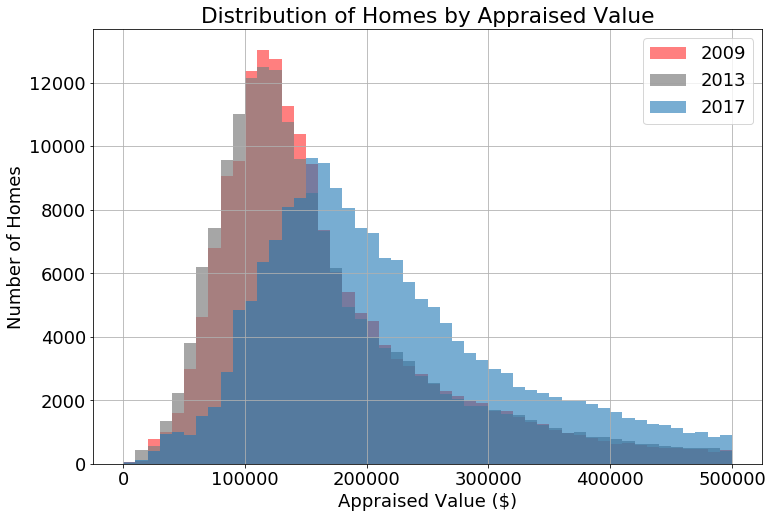

In [67]:
value_df2009['2009_appr'].plot(kind='hist',  bins=50, range=(0,500000), alpha=0.5, color='red', label ='2009')
value_df2013['2013_appr'].plot(kind='hist',  bins=50, range=(0,500000), alpha=0.7, color='gray', label='2013')
value_df2017['2017_appr'].plot(kind='hist',  bins=50, range=(0,500000), alpha=0.6, label='2017')
plt.xlabel('Appraised Value ($)')
plt.ylabel('Number of Homes')
plt.title('Distribution of Homes by Appraised Value')
plt.grid()
plt.legend();

In [21]:
sub_df_2009 = value_df2009.loc[value_df2009['2009_impr']>0,:]
sub_df_2009 = sub_df_2009.loc[:,['address', 'council_dist', 'zip','2009_appr', 'sq_ft']]
sub_df_2009['year'] = '2009'
sub_df_2009.columns = ['address', 'council_dist', 'zip','appr', 'sq_ft', 'year']

sub_df_2013 = value_df2013.loc[value_df2013['2013_impr']>0,:]
sub_df_2013 = sub_df_2013.loc[:,['address', 'council_dist', 'zip','2013_appr', 'sq_ft']]
sub_df_2013['year'] = '2013'
sub_df_2013.columns = ['address', 'council_dist', 'zip','appr', 'sq_ft', 'year']

sub_df_2017 = value_df2017.loc[value_df2017['2017_impr']>0,:]
sub_df_2017 = sub_df_2017.loc[:,['address', 'council_dist', 'zip','2017_appr', 'sq_ft']]
sub_df_2017['year'] = '2017'
sub_df_2017.columns = ['address', 'council_dist', 'zip','appr', 'sq_ft', 'year']


comb_price = pd.concat([sub_df_2009,sub_df_2013,sub_df_2017], sort = False, axis=0)


comb_price.head(10)

,address,council_dist,zip,appr,sq_ft,year
0,1012 OLD BUCK HILL RD,10,37072,115500.0,1920.0,2009
1,1109 HIGHLAND AVE,10,37072,132800.0,1464.0,2009
2,0 SPRINGFIELD HWY,10,37072,152900.0,3539.0,2009
3,133 B EAST END RD,10,37072,68100.0,736.0,2009
4,141 B EAST END RD,10,37072,86000.0,1301.0,2009
5,226 EAST END RD,10,37072,171600.0,1998.0,2009
6,231 EAST END RD,10,37072,115800.0,2028.0,2009
7,112 EAST END RD,10,37072,140300.0,2627.0,2009
8,156 B EAST END RD,10,37072,159900.0,1830.0,2009
9,148 EAST END RD,10,37072,35300.0,693.0,2009


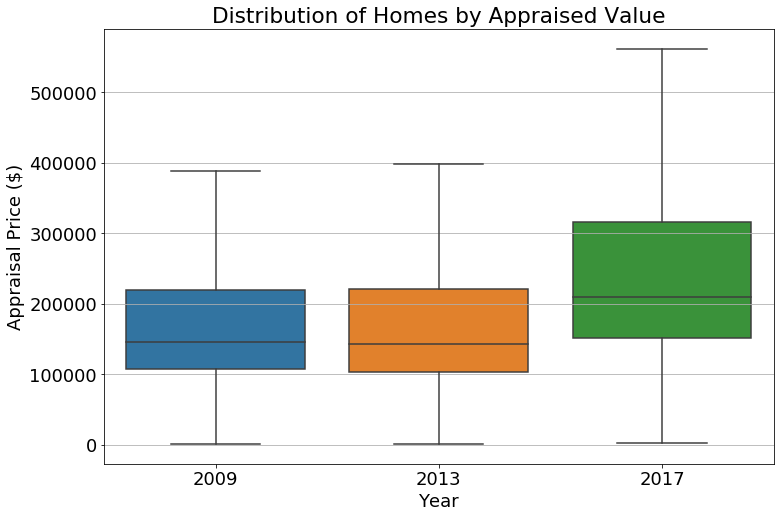

In [68]:
ax = sns.boxplot(x="year", y="appr", data=comb_price[comb_price['council_dist']!=99], showfliers=False, whis=1.5)
#plt.grid(axis='y')
plt.ylabel('Appraisal Price ($)')
plt.xlabel('Year')
plt.grid(axis = "y")
plt.title('Distribution of Homes by Appraised Value');


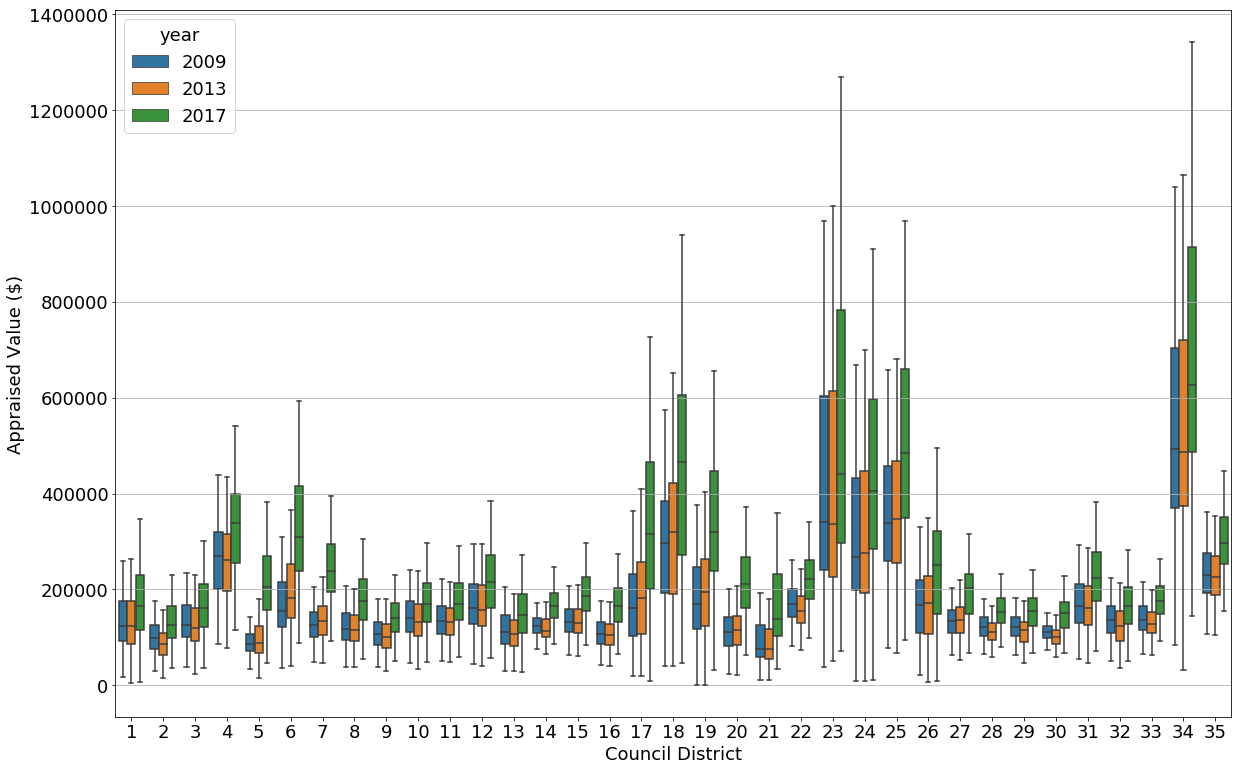

In [69]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 13)

sns.boxplot(x="council_dist", y="appr", hue='year', data =comb_price[comb_price['council_dist']!=99], showfliers=False, whis=1)
plt.ylabel('Appraised Value ($)')
plt.xlabel('Council District')
plt.grid(axis='y')

In [24]:
comb_grouped_median = comb_price[['zip', 'year', 'appr']].groupby(['zip', 'year']).median()
comb_grouped_median = comb_grouped_median[1:-2]
comb_grouped_median.sort_values(by='appr').head(10)

appr
zip   year          
37208 2013   74400.0
      2009   76800.0
37207 2013   93300.0
37218 2013   97500.0
37210 2009  100600.0
37207 2009  101200.0
37210 2013  101850.0
37218 2009  105500.0
37115 2013  107900.0
37217 2013  111300.0

In [25]:
def group_afford(df, minVal, maxVal):
    sub_df = df[(df['appr'] <= maxVal) & (df['sq_ft'] >= 800) & (df['appr'] >= minVal)]
    grouped_df = sub_df[['council_dist', 'year', 'appr']].groupby(['council_dist', 'year']).agg('count')
    grouped_df.columns = ['count']
    return grouped_df

In [26]:
count_85k = group_afford(comb_price, 0, 90000).reset_index().sort_values(by=['year','count'], ascending=[True, False])
count_85k.head(10)

,council_dist,year,count
12,5,2009,2140
59,21,2009,2080
3,2,2009,1515
0,1,2009,1279
36,13,2009,1216
24,9,2009,1167
30,11,2009,1002
21,8,2009,932
80,29,2009,886
18,7,2009,884


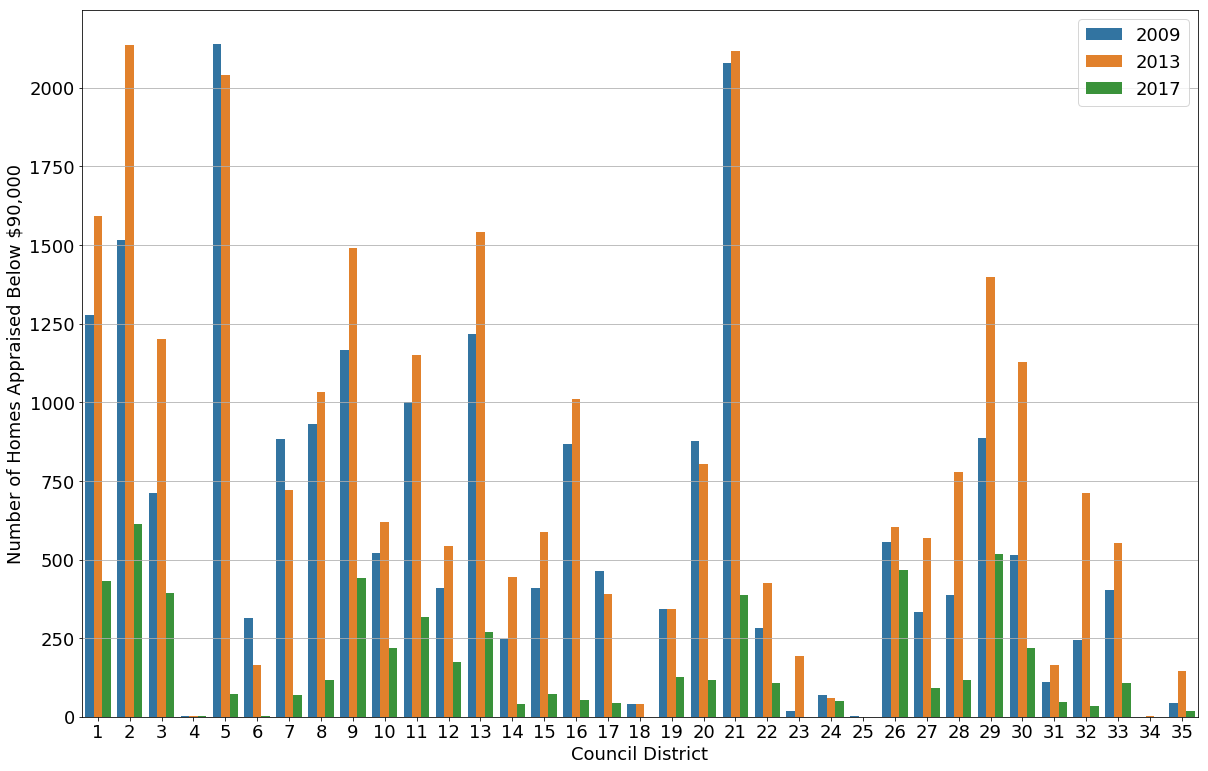

In [70]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 13)

sns.barplot(x="council_dist", y="count", hue='year', data=count_85k)
plt.ylabel('Number of Homes Appraised Below $90,000')
plt.xlabel('Council District')
plt.legend(loc=1)
plt.grid(axis='y')

In [28]:
code_list = ['CAA01R301', 'CAA02R302', 'CAA03R201', 'CAA03R298','CAA03R299', 'CAA03R301', 
             'CAA03R398', 'CAA03R399', 'CAA04R301', 'CAA05R202', 'CAA08R301', 'CAA15R301', 
             'CAZ09A001','DPLX2CNDO']
build_sub = build_permits.loc[build_permits['permit_subtype'].isin(code_list), :]
build_sub.shape

(19263, 20)

In [29]:
def group_income(row):
    if row['year'] == 2009:
        if row['appr'] < 95600: # price for mortgage of $487.50 per month
            return "30% of AMI"
        elif row['appr'] >= 95600 and row['appr'] < 191500: # price for mortgage of $975 per month
            return "60% of AMI"
        elif row['appr'] >= 191500 and row['appr'] < 255000: # price for mortgage of $1300 per month
            return "80% of AMI"
        elif row['appr'] >= 255000 and row['appr'] <= 382500: # price for mortgage of $1950 per month
            return "120% of AMI"
        else:
            return "Not Affordable"
        
    elif row['year'] == 2013:
        if row['appr'] < 91700: # price for mortgage of $467.25 per month
            return "30% of AMI"
        elif row['appr'] >= 91700 and row['appr'] < 183000: # price for mortgage of $934.50 per month
            return "60% of AMI"
        elif row['appr'] >= 183000 and row['appr'] < 244300: # price for mortgage of $1246 per month
            return "80% of AMI"
        elif row['appr'] >= 244300 and row['appr'] <= 366500: # price for mortgage of $1869 per month
            return "120% of AMI"
        else:
            return "Not Affordable"
        
    else:
        if row['appr'] < 100000: # price for mortgage of $510 per month
            return "30% of AMI"
        elif row['appr'] >= 100000 and row['appr'] < 200000: # price for mortgage of $1020 per month
            return "60% of AMI"
        elif row['appr'] >= 200000 and row['appr'] < 266700: # price for mortgage of $1360 per month
            return "80% of AMI"
        elif row['appr'] >= 266700 and row['appr'] <= 400000: # price for mortgage of $2040 per month
            return "120% of AMI"
        else:
            return "Not Affordable"

comb_price['income_bracket'] = comb_price.apply(group_income, axis=1)
comb_price.head(10)

,address,council_dist,zip,appr,sq_ft,year,income_bracket
0,1012 OLD BUCK HILL RD,10,37072,115500.0,1920.0,2009,60% of AMI
1,1109 HIGHLAND AVE,10,37072,132800.0,1464.0,2009,60% of AMI
2,0 SPRINGFIELD HWY,10,37072,152900.0,3539.0,2009,60% of AMI
3,133 B EAST END RD,10,37072,68100.0,736.0,2009,30% of AMI
4,141 B EAST END RD,10,37072,86000.0,1301.0,2009,30% of AMI
5,226 EAST END RD,10,37072,171600.0,1998.0,2009,60% of AMI
6,231 EAST END RD,10,37072,115800.0,2028.0,2009,60% of AMI
7,112 EAST END RD,10,37072,140300.0,2627.0,2009,60% of AMI
8,156 B EAST END RD,10,37072,159900.0,1830.0,2009,60% of AMI
9,148 EAST END RD,10,37072,35300.0,693.0,2009,30% of AMI


In [30]:
comb_price.tail(10)

,address,council_dist,zip,appr,sq_ft,year,income_bracket
197093,1427 WINDING CREEK DR,33,37135,232000.0,1728.0,2017,80% of AMI
197094,1425 WINDING CREEK DR,33,37135,220500.0,1728.0,2017,80% of AMI
197095,1423 WINDING CREEK DR,33,37135,253700.0,1920.0,2017,80% of AMI
197103,1612 CARSON MEADOWS LN,33,37135,259300.0,1932.5,2017,80% of AMI
197108,1705 PARK TERRACE LN,33,37135,126600.0,1564.0,2017,60% of AMI
197109,1709 PARK TERRACE LN,33,37135,334600.0,2831.0,2017,120% of AMI
197110,1713 PARK TERRACE LN,33,37135,337400.0,2774.0,2017,120% of AMI
197111,1717 PARK TERRACE LN,33,37135,408800.0,3222.0,2017,Not Affordable
197112,2104 GLEN HAVEN DR,33,37135,220300.0,1952.0,2017,80% of AMI
197113,2103 GLEN HAVEN DR,33,37135,252700.0,2077.5,2017,80% of AMI


In [31]:
income_by_year = comb_price[['year', 'income_bracket', 'appr']].groupby(['year', 'income_bracket']).agg('count').reset_index()
income_by_year.columns=['year','income_bracket', 'count']


In [32]:
income_by_year

,year,income_bracket,count
0,2009,120% of AMI,18572
1,2009,30% of AMI,36130
2,2009,60% of AMI,92810
3,2009,80% of AMI,21527
4,2009,Not Affordable,13952
5,2013,120% of AMI,18519
6,2013,30% of AMI,42639
7,2013,60% of AMI,88891
8,2013,80% of AMI,21233
9,2013,Not Affordable,14963


Text(0.5,1,'Change in Affordable Homes by Income Bracket as Percent of Area Median Income')

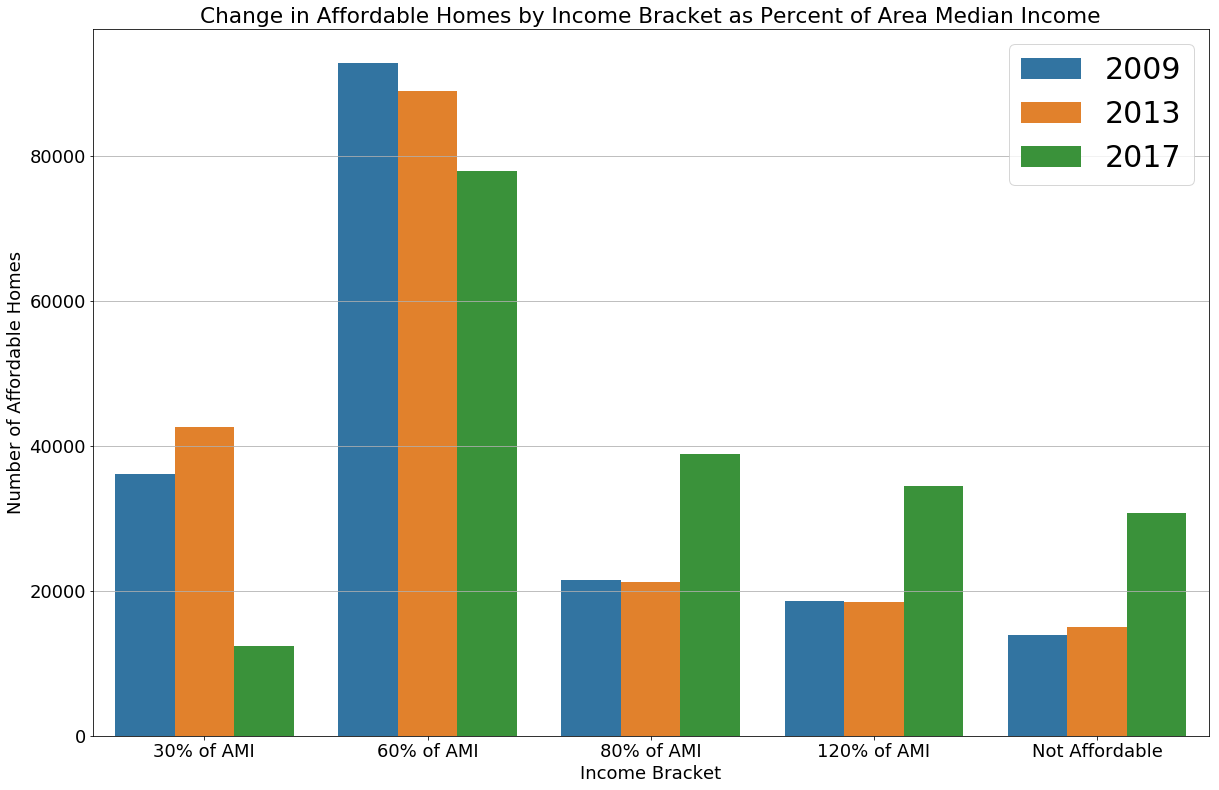

In [73]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 13)

sns.barplot(x="income_bracket", y="count", hue='year', data=income_by_year, order=['30% of AMI', '60% of AMI', '80% of AMI', '120% of AMI', 'Not Affordable'])
plt.ylabel('Number of Affordable Homes')
plt.xlabel('Income Bracket')
plt.legend(loc='upper right', prop={'size': 30})
plt.grid(axis='y')
plt.title("Change in Affordable Homes by Income Bracket as Percent of Area Median Income")

In [34]:
income_by_dist = comb_price[['council_dist', 'year', 'income_bracket', 'appr']].groupby(['council_dist', 'year', 'income_bracket']).agg('count')#.reset_index()
#income_by_dist.columns=['council_dist', 'year','income_bracket', 'count']
income_by_dist.head(15)

appr
council_dist year income_bracket      
1            2009 120% of AMI      308
                  30% of AMI      1869
                  60% of AMI      3078
                  80% of AMI       575
                  Not Affordable    69
             2013 120% of AMI      322
                  30% of AMI      2203
                  60% of AMI      2784
                  80% of AMI       570
                  Not Affordable    76
             2017 120% of AMI      712
                  30% of AMI       914
                  60% of AMI      2886
                  80% of AMI      1286
                  Not Affordable   210

In [35]:
irs_2009 = pd.read_csv('Data/zipcodeagi09.csv')
irs_2013 = pd.read_csv('Data/zipcodeagi13.csv')
irs_2016 = pd.read_csv('Data/zipcodeagi16.csv')
irs_2009['Year'] = '2009'
irs_2013['Year'] = '2013'
irs_2016['Year'] = '2016'

irs_2009.tail(6)


,STATEFIPS,STATE,zipcode,agi_stub,N1,MARS2,PREP,N2,NUMDEP,A00100,...,A09600,N06500,A06500,N10300,A10300,N11901,A11901,N11902,A11902,Year
3528,47,TN,38588,1,205.0000,74.0000,153.0000,416.0000,147.0000,2507.0000,...,0.0,55.0000,25.0000,112.0000,96.0000,36.0000,47.0000,174.0000,468.0000,2009
3529,47,TN,38588,2,96.0000,56.0000,62.0000,227.0000,90.0000,3486.0000,...,0.0,68.0000,161.0000,76.0000,182.0000,0.0001,0.0001,87.0000,262.0000,2009
3530,47,TN,38588,3,41.0000,35.0000,28.0000,92.0000,0.0001,2458.0000,...,0.0,40.0000,185.0000,40.0000,202.0000,0.0001,0.0001,52.0000,182.0000,2009
3531,47,TN,38588,4,26.0000,20.0000,20.0000,71.0000,24.0000,2497.0000,...,0.0,25.0000,270.0000,25.0000,311.0000,0.0001,0.0001,0.0001,0.0001,2009
3532,47,TN,38588,5,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,2009
3533,47,TN,38588,6,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2009


In [36]:
irs_2016.rename(columns={'N1': 'Returns', 'A00100': 'AGI(k)','N02650': 'Returns Tot Inc', 
                         'A02650': 'Total Income','MARS1':'Single Returns','MARS2':'Joint Returns',
                         'MARS4':'HOH Returns'}, inplace=True)
irs_2013.rename(columns={'N1': 'Returns', 'A00100': 'AGI(k)','N02650': 'Returns Tot Inc', 
                         'A02650': 'Total Income','MARS1':'Single Returns','MARS2':'Joint Returns',
                         'MARS4':'HOH Returns'}, inplace=True)
irs_2009.rename(columns={'N1': 'Returns', 'A00100': 'AGI(k)','N02650': 'Returns Tot Inc', 
                         'A02650': 'Total Income','MARS1':'Single Returns','MARS2':'Joint Returns',
                         'MARS4':'HOH Returns'}, inplace=True)

In [37]:
irs_2009_sub = irs_2009[['zipcode','agi_stub','Returns','Joint Returns','AGI(k)','Year']]
irs_2013_sub = irs_2013[['zipcode','agi_stub','Returns','Joint Returns','AGI(k)','Year']]
irs_2016_sub = irs_2016[['zipcode','agi_stub','Returns','Joint Returns','AGI(k)','Year']]


In [38]:
irs_2013_sub.head()

,zipcode,agi_stub,Returns,Joint Returns,AGI(k),Year
0,0,1,1227610,179340,15439170,2013
1,0,2,719920,237450,25840632,2013
2,0,3,372940,223080,22908270,2013
3,0,4,222260,174860,19235337,2013
4,0,5,250400,216310,33610574,2013


In [39]:
irs_2016_sub.head()

,zipcode,agi_stub,Returns,Joint Returns,AGI(k),Year
0,0,1,1157130,155040,14655937,2016
1,0,2,759390,217720,27373973,2016
2,0,3,397080,216320,24381023,2016
3,0,4,241840,182240,20948708,2016
4,0,5,299360,255470,40303223,2016


In [40]:
irs_2009_sub.shape

(3534, 6)

In [41]:
dav_zip_codes = comb_price['zip'].unique().tolist()
len(dav_zip_codes)

34

In [42]:
irs_2009_dav = irs_2009_sub.loc[irs_2009_sub['zipcode'].isin(dav_zip_codes), :]
irs_2013_dav = irs_2013_sub.loc[irs_2013_sub['zipcode'].isin(dav_zip_codes), :]
irs_2016_dav = irs_2016_sub.loc[irs_2016_sub['zipcode'].isin(dav_zip_codes), :]

irs_2009_dav.tail(20)

,zipcode,agi_stub,Returns,Joint Returns,AGI(k),Year
754,37219,5,93.0000,34.0000,12445.0000,2009
755,37219,6,50.0000,33.0000,33029.0000,2009
756,37220,1,904.0000,126.0000,9585.0000,2009
757,37220,2,476.0000,162.0000,17586.0000,2009
758,37220,3,421.0000,224.0000,26191.0000,2009
759,37220,4,380.0000,287.0000,32953.0000,2009
760,37220,5,620.0000,540.0000,84498.0000,2009
761,37220,6,371.0000,340.0000,212325.0000,2009
762,37221,1,5659.0000,759.0000,66313.0000,2009
763,37221,2,4274.0000,1108.0000,157981.0000,2009


In [43]:
comb_irs = pd.concat([irs_2009_dav,irs_2013_dav,irs_2016_dav], sort = False, axis=0)
comb_irs.shape

(612, 6)

In [44]:
def irs_income_bracket(row):
    agi_group = row['agi_stub']
    if agi_group == 1:
        return '\$1-\$24,999'
    elif agi_group == 2:
        return '\$25,000-\$49,999'
    elif agi_group == 3:
        return '\$50,000-\$74,999'
    elif agi_group == 4:
        return '\$75,000-\$99,999'
    elif agi_group == 5:
        return '\$100,000-\$199,999'
    elif agi_group == 6:
        return '\$200,000 or More'

comb_irs['income_bracket'] = comb_irs.apply(irs_income_bracket, axis=1)
comb_irs.head(10)

,zipcode,agi_stub,Returns,Joint Returns,AGI(k),Year,income_bracket
18,37013,1,15587.0,1986.0,208591.0,2009,"\$1-\$24,999"
19,37013,2,12050.0,2860.0,429997.0,2009,"\$25,000-\$49,999"
20,37013,3,4663.0,2412.0,283652.0,2009,"\$50,000-\$74,999"
21,37013,4,2290.0,1751.0,196489.0,2009,"\$75,000-\$99,999"
22,37013,5,1451.0,1219.0,181305.0,2009,"\$100,000-\$199,999"
23,37013,6,77.0,62.0,22181.0,2009,"\$200,000 or More"
30,37015,1,3242.0,610.0,40630.0,2009,"\$1-\$24,999"
31,37015,2,2275.0,872.0,82238.0,2009,"\$25,000-\$49,999"
32,37015,3,1164.0,863.0,71592.0,2009,"\$50,000-\$74,999"
33,37015,4,619.0,548.0,53454.0,2009,"\$75,000-\$99,999"


In [45]:
irs_by_year = comb_irs[['Year', 'income_bracket', 'Returns']].groupby(['Year', 'income_bracket']).sum().reset_index()
irs_by_year.columns=['year','income_bracket', 'total_returns']


In [46]:
irs_by_year

,year,income_bracket,total_returns
0,2009,"\$1-\$24,999",162595.0000
1,2009,"\$100,000-\$199,999",34639.0000
2,2009,"\$200,000 or More",13335.0004
3,2009,"\$25,000-\$49,999",104797.0000
4,2009,"\$50,000-\$74,999",50765.0000
5,2009,"\$75,000-\$99,999",29147.0001
6,2013,"\$1-\$24,999",167940.0000
7,2013,"\$100,000-\$199,999",44470.0000
8,2013,"\$200,000 or More",20020.0000
9,2013,"\$25,000-\$49,999",112600.0000


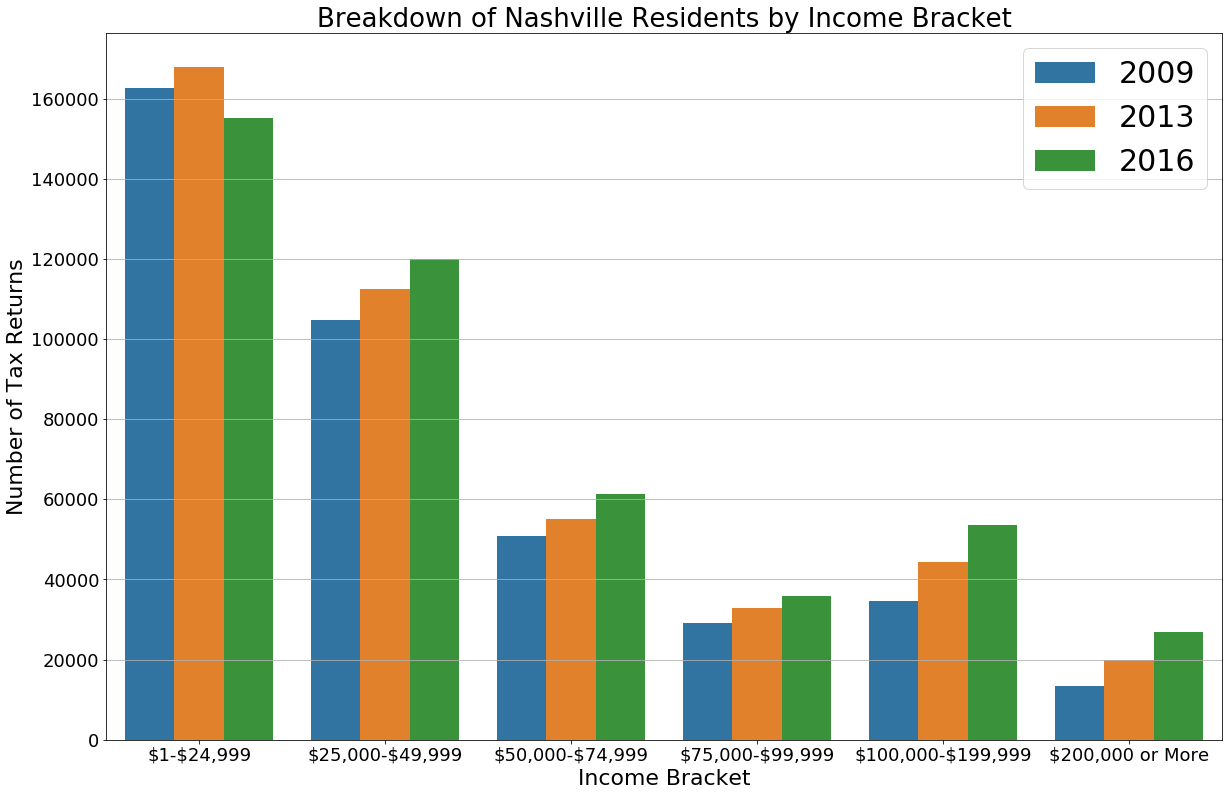

In [72]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 13)

sns.barplot(x="income_bracket", y="total_returns", hue='year', data=irs_by_year, order=['\$1-\$24,999', '\$25,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', '\$100,000-\$199,999', '\$200,000 or More'])
plt.ylabel('Number of Tax Returns', fontsize=22)
plt.xlabel('Income Bracket', fontsize=22)
plt.title('Breakdown of Nashville Residents by Income Bracket', fontsize=26)
plt.legend(loc='upper right', prop={'size': 30})
plt.grid(axis='y')

In [48]:
irs_total = comb_irs[['Year', 'Returns']].groupby(['Year']).sum().reset_index()
irs_total.columns=['year', 'total_returns']
irs_total

,year,total_returns
0,2009,395278.0005
1,2013,432910.0000
2,2016,452830.0000


In [49]:
sf2009=pd.read_csv('Data/2009_single family_final_with_sqft.txt')
sf2013=pd.read_csv('Data/2013_single family_final_with_sqft.txt')
sf2017=pd.read_csv('Data/2017_single family_final_with_sqft.txt')

In [50]:
sf2009['Year'] = '2009'
sf2009.columns=['APN', 'District Code', 'Council District', 'Street Address', 'City', 'Zip Code', 'Land Val', 'Improvement Val', 'Appraised Val', 'Assessed Val','sq_ft','Year' ]

sf2013['Year'] = '2013'
sf2013.columns=['APN', 'District Code', 'Council District', 'Street Address', 'City', 'Zip Code', 'Land Val', 'Improvement Val', 'Appraised Val', 'Assessed Val','sq_ft', 'Year' ]

sf2017['Year'] = '2016'
sf2017.columns=['APN', 'District Code', 'Council District', 'Street Address', 'City', 'Zip Code', 'Land Val', 'Improvement Val', 'Appraised Val', 'Assessed Val','sq_ft','Year' ]


housing= pd.concat([sf2009,sf2013,sf2017], sort = False, axis=0)
housing.shape

(566789, 12)

In [51]:
housing = housing.loc[housing['Improvement Val']>0,:]
housing.shape

(563689, 12)

In [52]:
CTR={'BM  ':0.03012,'BH  ':0.02755,'FH  ':0.02755,'GO  ':0.03503,'OH  ':0.02755,'RT  ':0.03437,'CBID':0.032844,'GBID':0.032631,'GSD ':0.02755,'USD ':0.03155}
def tax(df_codes,df_assd,codetax=0.02755):
        codetax=[CTR.get(code, codetax) for code in df_codes]
        result=codetax*df_assd
        return result

In [53]:
housing['Taxes']=tax(housing.iloc[:,1],housing.iloc[:,9])


In [54]:
y=30 #number of years to pay on loan (i.e. 15, 20, 30 etc.)
n=y*12 #number of payments for life of loan
i=.05 #Current APR estimation
r=i/12
dp=0.05 #down payment percentage
    
def mortgagepay_2(row, df_appraised_column='Appraised Val',df_taxes='Taxes'):
    principalpay=((row[df_appraised_column]-(dp*row[df_appraised_column]))*((1+r)**n)*(r/(((1+r)**n)-1)))
    mortgagepay=round(principalpay+100+(row[df_taxes]/12),2) #$100 is for homeowner's insurance
    return mortgagepay
# Homeowner's insurance https://quotewizard.com/home-insurance/tennessee

In [55]:
housing['MP']=housing.apply(lambda x: mortgagepay_2(x, df_appraised_column='Appraised Val',df_taxes='Taxes'), axis=1)

In [56]:
housing.head()

,APN,District Code,Council District,Street Address,City,Zip Code,Land Val,Improvement Val,Appraised Val,Assessed Val,sq_ft,Year,Taxes,MP
0,00200000300,RT,10,1012 OLD BUCK HILL RD,GOODLETTSVILLE,37072,49800.0,65700.0,115500.0,28875.0,1920.0,2009,992.43375,771.73
1,00200000700,RT,10,1109 HIGHLAND AVE,GOODLETTSVILLE,37072,44100.0,88700.0,132800.0,33200.0,1464.0,2009,1141.08400,872.34
2,00200001001002,GSD,10,0 SPRINGFIELD HWY,GOODLETTSVILLE,37072,15000.0,137900.0,152900.0,38225.0,3539.0,2009,1053.09875,967.52
3,00200001400001,RT,10,133 B EAST END RD,GOODLETTSVILLE,37072,41100.0,27000.0,68100.0,17025.0,736.0,2009,585.14925,496.06
4,00200001600001,RT,10,141 B EAST END RD,GOODLETTSVILLE,37072,25100.0,60900.0,86000.0,21500.0,1301.0,2009,738.95500,600.16


In [57]:
def demand_approx(df):
        if df['MP'] <(625):
            return '\$1-\$24,999'
        elif df['MP'] <(1250) and df['MP']>=(625):
            return '\$25,000-\$49,999'
        elif df['MP'] <(1875)and df['MP']>=(1250):
            return '\$50,000-\$74,999'
        elif df['MP'] <(2500) and df['MP']>=(1875):
            return '\$75,000-\$99,999'
        elif df['MP'] <(5000) and df['MP']>=(2500):
            return '\$100,000-\$199,999'
        else: 
            return '\$200,000 or More'

In [58]:
housing['IRS Comp']=housing.apply(demand_approx, axis=1)


In [59]:
housing.head()

,APN,District Code,Council District,Street Address,City,Zip Code,Land Val,Improvement Val,Appraised Val,Assessed Val,sq_ft,Year,Taxes,MP,IRS Comp
0,00200000300,RT,10,1012 OLD BUCK HILL RD,GOODLETTSVILLE,37072,49800.0,65700.0,115500.0,28875.0,1920.0,2009,992.43375,771.73,"\$25,000-\$49,999"
1,00200000700,RT,10,1109 HIGHLAND AVE,GOODLETTSVILLE,37072,44100.0,88700.0,132800.0,33200.0,1464.0,2009,1141.08400,872.34,"\$25,000-\$49,999"
2,00200001001002,GSD,10,0 SPRINGFIELD HWY,GOODLETTSVILLE,37072,15000.0,137900.0,152900.0,38225.0,3539.0,2009,1053.09875,967.52,"\$25,000-\$49,999"
3,00200001400001,RT,10,133 B EAST END RD,GOODLETTSVILLE,37072,41100.0,27000.0,68100.0,17025.0,736.0,2009,585.14925,496.06,"\$1-\$24,999"
4,00200001600001,RT,10,141 B EAST END RD,GOODLETTSVILLE,37072,25100.0,60900.0,86000.0,21500.0,1301.0,2009,738.95500,600.16,"\$1-\$24,999"


In [60]:
irs_supply = housing[['Year', 'IRS Comp', 'APN']].groupby(['Year', 'IRS Comp']).agg('count').reset_index()
irs_supply.columns=['year','income_bracket', 'total_returns']


In [61]:
irs_supply['supply_demand'] = 'Supply'
irs_supply

,year,income_bracket,total_returns,supply_demand
0,2009,"\$1-\$24,999",27838,Supply
1,2009,"\$100,000-\$199,999",9969,Supply
2,2009,"\$200,000 or More",2812,Supply
3,2009,"\$25,000-\$49,999",101505,Supply
4,2009,"\$50,000-\$74,999",29529,Supply
5,2009,"\$75,000-\$99,999",11338,Supply
6,2013,"\$1-\$24,999",33106,Supply
7,2013,"\$100,000-\$199,999",10563,Supply
8,2013,"\$200,000 or More",3030,Supply
9,2013,"\$25,000-\$49,999",98856,Supply


In [62]:
irs_by_year['supply_demand'] = 'Demand'
irs_by_year

,year,income_bracket,total_returns,supply_demand
0,2009,"\$1-\$24,999",162595.0000,Demand
1,2009,"\$100,000-\$199,999",34639.0000,Demand
2,2009,"\$200,000 or More",13335.0004,Demand
3,2009,"\$25,000-\$49,999",104797.0000,Demand
4,2009,"\$50,000-\$74,999",50765.0000,Demand
5,2009,"\$75,000-\$99,999",29147.0001,Demand
6,2013,"\$1-\$24,999",167940.0000,Demand
7,2013,"\$100,000-\$199,999",44470.0000,Demand
8,2013,"\$200,000 or More",20020.0000,Demand
9,2013,"\$25,000-\$49,999",112600.0000,Demand


In [63]:
irs_total = pd.concat([irs_by_year, irs_supply], sort=False, axis=0)
irs_total

,year,income_bracket,total_returns,supply_demand
0,2009,"\$1-\$24,999",162595.0000,Demand
1,2009,"\$100,000-\$199,999",34639.0000,Demand
2,2009,"\$200,000 or More",13335.0004,Demand
3,2009,"\$25,000-\$49,999",104797.0000,Demand
4,2009,"\$50,000-\$74,999",50765.0000,Demand
5,2009,"\$75,000-\$99,999",29147.0001,Demand
6,2013,"\$1-\$24,999",167940.0000,Demand
7,2013,"\$100,000-\$199,999",44470.0000,Demand
8,2013,"\$200,000 or More",20020.0000,Demand
9,2013,"\$25,000-\$49,999",112600.0000,Demand


In [64]:
irs_2009 = irs_total[irs_total['year']=='2009']
irs_2013 = irs_total[irs_total['year']=='2013']
irs_2016 = irs_total[irs_total['year']=='2016']

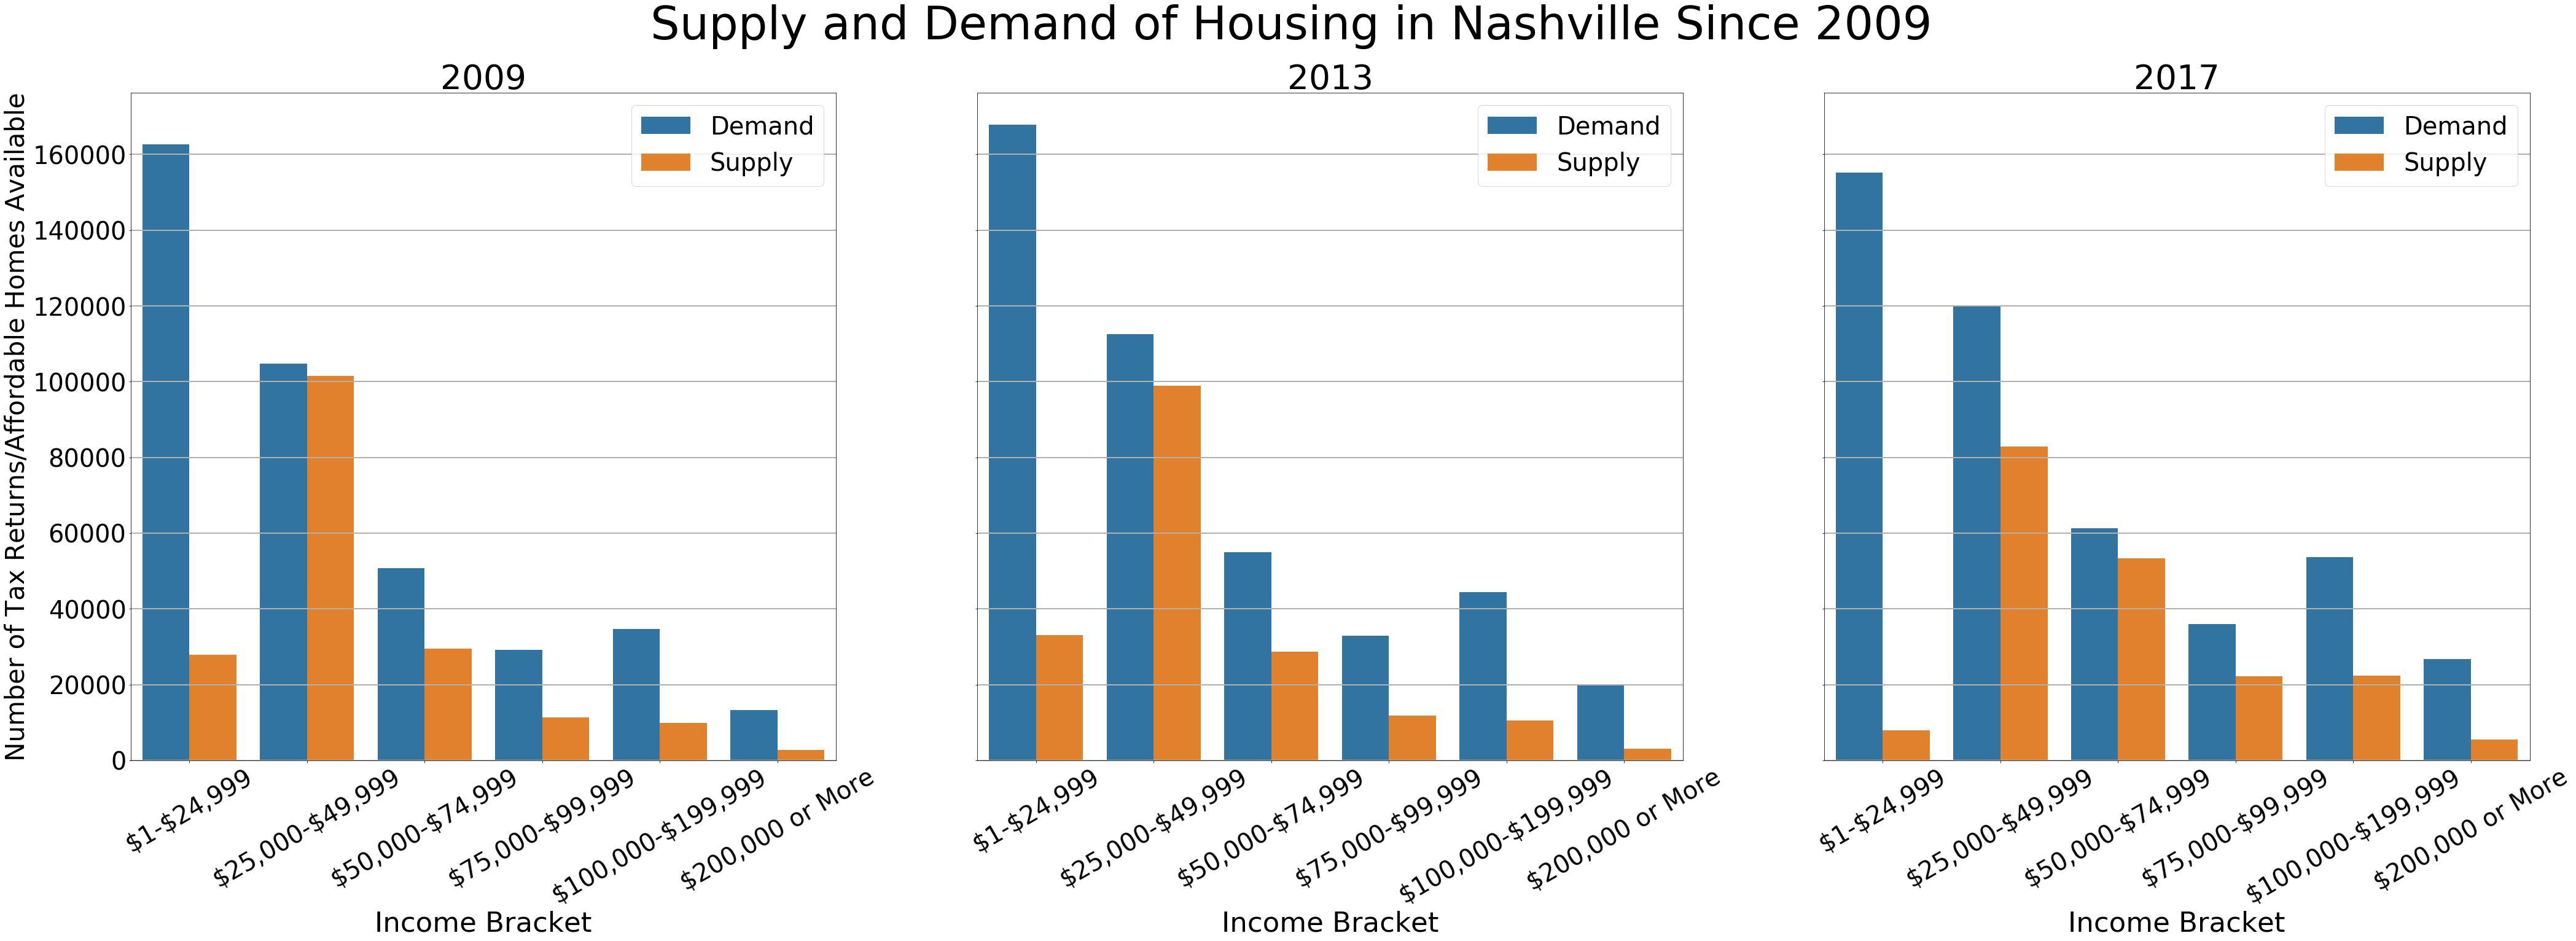

In [65]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharey=True)
fig.set_size_inches(70, 20)
fig.suptitle('Supply and Demand of Housing in Nashville Since 2009', fontsize=75)
ax1.tick_params(axis='y',labelsize=40, grid_linewidth=2, grid_linestyle='-')
ax1.tick_params(axis='x',labelsize=40, rotation=30)

sns.barplot(x="income_bracket", y="total_returns", hue='supply_demand', data=irs_total[irs_total['year']=='2009'], 
            order=['\$1-\$24,999', '\$25,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', 
                   '\$100,000-\$199,999', '\$200,000 or More'], ax=ax1)
ax1.set_title('2009', fontsize=55)

ax1.set_ylabel('Number of Tax Returns/Affordable Homes Available', fontsize=42)
ax1.set_xlabel('Income Bracket', fontsize=45)
ax1.legend(loc='upper right', prop={'size': 40})
ax1.grid(axis='y', linewidth=2)

sns.barplot(x="income_bracket", y="total_returns", hue='supply_demand', data=irs_total[irs_total['year']=='2013'], 
            order=['\$1-\$24,999', '\$25,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', '\$100,000-\$199,999',
                   '\$200,000 or More'],ax=ax2)
ax2.set_ylabel('', fontsize=40)
ax2.set_xlabel('Income Bracket', fontsize=45)
ax2.set_title('2013', fontsize=55)
ax2.legend(loc='upper right', prop={'size': 40})
ax2.tick_params(axis='y',labelsize=40, grid_linewidth=2)
ax2.tick_params(axis='x',labelsize=40, rotation=30)
ax2.grid(axis='y', linewidth=2)

sns.barplot(x="income_bracket", y="total_returns", hue='supply_demand', data=irs_total[irs_total['year']=='2016'], 
            order=['\$1-\$24,999', '\$25,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', 
                   '\$100,000-\$199,999', '\$200,000 or More'], ax=ax3)
ax3.set_ylabel('', fontsize=40)
ax3.set_xlabel('Income Bracket', fontsize=45)
ax3.set_title('2017', fontsize=55)
ax3.legend(loc='upper right', prop={'size': 40})
ax3.tick_params(axis='y',labelsize=40, grid_linewidth=2)
ax3.tick_params(axis='x',labelsize=40, rotation=30)
ax3.grid(axis='y', linewidth=2)